In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import umap
import time
import datetime
from deepAutoencoder import *
from betaVAE import *
from betaVSC import *
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
device = torch.device("cpu")

**NOTE about training times: Model training done on hp elite book, intel core i7 8th gen**


## Data loading and helper functions
**Dataset**: PBMC3k  
**Datatype**: single cell RNA sequencing data (normalized count data).  
Features (columns) are genes, Samples (rows) repsresent individual cells.

In [4]:
# Pytorch Dataloader
class CellDataset(Dataset):
    """ Cell dataset."""

    # Initialize your data, load and remove unecessary first row
    def __init__(self):
        
        df = pd.read_csv('data/scPBMC.csv', delimiter=',')
        X = np.transpose(df.values)
        X = X[1:,:] #remove the first row
        X = X.astype(float)
        self.len = X.shape[0]
        self.x_data = torch.from_numpy(X)
        
        labels = pd.read_csv("data/pbmc_labels_int.csv")
        self.y_data = torch.from_numpy(labels.values[:,1:])

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len
    
################################################################
################################################################
# Helper function for plotting tsne embedding
def plot_tsne(codes, labels, title):
    codes = np.vstack(codes)

    if codes.shape[1] > 2:
        print('plotting latent space with tsne ... ')
        codes = TSNE().fit_transform(codes)

    labels = np.vstack(labels)
    labels = [item for sublist in labels for item in sublist]
    df = pd.DataFrame(dict(x=codes[:, 0], y=codes[:, 1], label=labels))
    groups = df.groupby('label')
    plt.rcParams["figure.figsize"] = [18,18]
    fig, ax = plt.subplots()
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=4, label=dictlabels[name],)
    ax.legend(loc="upper right")
    ax.set_title(title)
    plt.show()
    return 
    
################################################################
################################################################
# Load data
dataset = CellDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=240,
                          shuffle=True)

test_loader = DataLoader(dataset=dataset,
                         batch_size=5,
                         shuffle=False)

################################################################
################################################################
# CLuster labels produced by Seurat clustering are in file "pbmc_labels_str.csv"
# dictlabels variable is used for tsne-plots
labels_str = pd.read_csv("data/pbmc_labels_str.csv")
valuelbl = [5, 7, 3, 0, 4, 1, 6, 8, 2]
dictlabels = dict(zip(valuelbl, list(set(labels_str.labels))))



## Deep Autoencoder

In [3]:
# Create autoencoder instance
autoencoder = Autoencoder(latent_size=6)
autoencoder.to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

## TRAINING DEEP AUTOENCODER

In [5]:
# TRAIN FOR 200 EPOCHS
print_every=75
t0=time.time()
for epoch in range(200):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs = inputs.to(device)
        optimizer.zero_grad()
        x_hat = autoencoder(inputs.float())
        loss = MSE_loss(x_hat, inputs.float())
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % print_every == 0:    # print every 15 mini-batches
            print('loss: ', loss.item(), 'epoch: ', epoch)
t1=time.time()

print('Finished Training')

loss:  983430.5625 epoch:  0
loss:  882915.375 epoch:  1
loss:  681254.5 epoch:  2
loss:  528398.1875 epoch:  3
loss:  492531.9375 epoch:  4
loss:  476842.0625 epoch:  5
loss:  469227.375 epoch:  6
loss:  464305.1875 epoch:  7
loss:  465901.875 epoch:  8
loss:  461542.03125 epoch:  9
loss:  466627.28125 epoch:  10
loss:  473478.4375 epoch:  11
loss:  465477.40625 epoch:  12
loss:  472165.125 epoch:  13
loss:  459913.0 epoch:  14
loss:  456397.1875 epoch:  15
loss:  465794.84375 epoch:  16
loss:  466433.5 epoch:  17
loss:  467770.46875 epoch:  18
loss:  467702.09375 epoch:  19
loss:  463580.84375 epoch:  20
loss:  456775.875 epoch:  21
loss:  457215.125 epoch:  22
loss:  451637.21875 epoch:  23
loss:  447133.625 epoch:  24
loss:  445393.65625 epoch:  25
loss:  446804.9375 epoch:  26
loss:  443745.6875 epoch:  27
loss:  452347.8125 epoch:  28
loss:  442476.6875 epoch:  29
loss:  446906.59375 epoch:  30
loss:  438583.53125 epoch:  31
loss:  437833.40625 epoch:  32
loss:  432999.4375 epoch

Model training time: 0:03:26
plotting latent space with tsne ... 


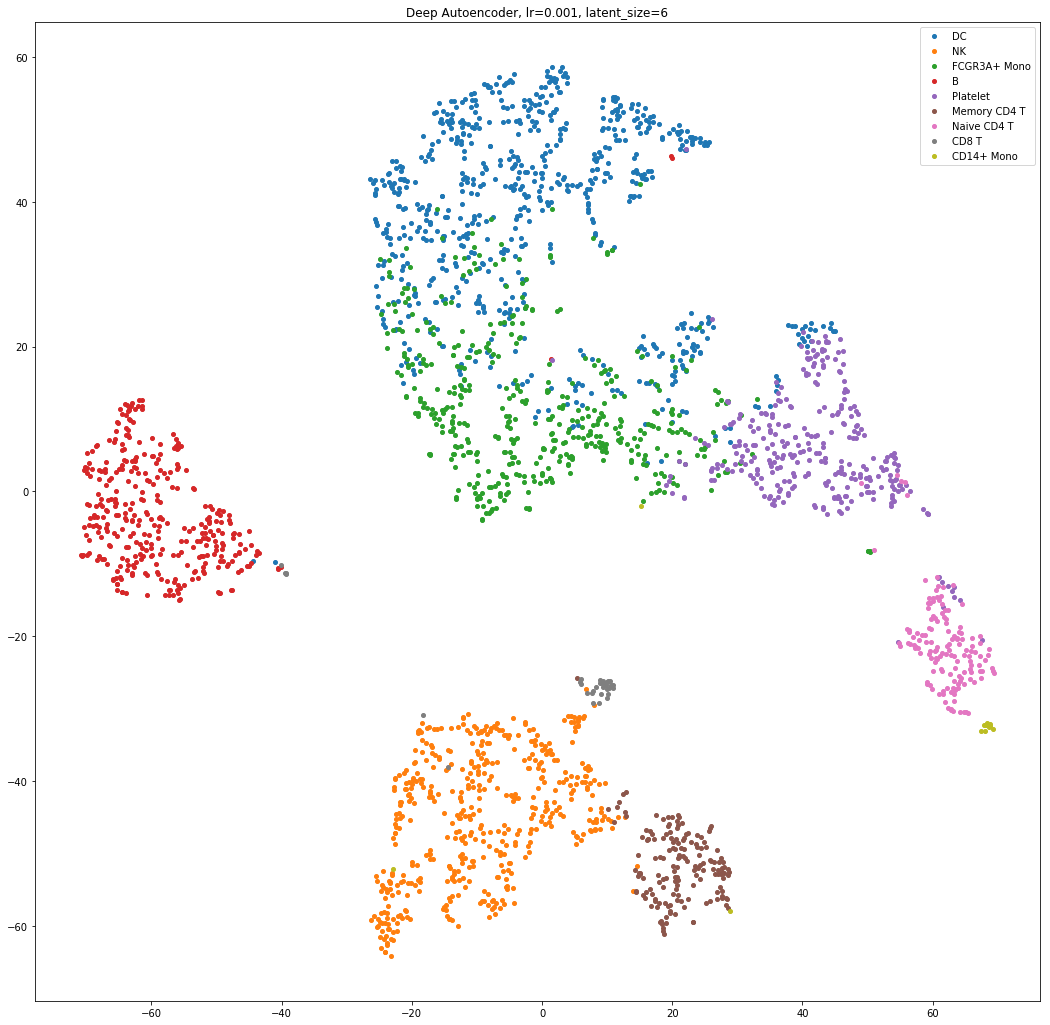

In [6]:
# PLOT THE LATENT DIMENSION
print("Model training time:", datetime.timedelta(seconds=round(t1-t0,0)))
codes, labels = [], []

for i in range(len(train_loader.dataset)):
    z = autoencoder.encode(train_loader.dataset.x_data[i].float())
    label = train_loader.dataset.y_data[i]
    labels.append(label.data.numpy())
    codes.append(z.data.numpy())

    
plot_tsne(codes, labels, 'Deep Autoencoder, lr=0.001, latent_size=6')

## $\beta$-VAE

In [7]:
betaVae1 = betaVAE(latent_size=6)
betaVae1.to(device)
optimizer = torch.optim.Adam(betaVae1.parameters(), lr=0.001)

In [ ]:
# Beta value set to 1
t0=time.time()
train_betaVAE(beta=2.0, betaVae=betaVae1, train_loader=train_loader, device=device, optimizer=optimizer)
t1=time.time()

Beta value:  2.0
loss:  980506.4375 epoch:  0
loss:  583240.25 epoch:  1
loss:  487464.6875 epoch:  2
loss:  481073.8125 epoch:  3
loss:  475007.75 epoch:  4
loss:  474354.75 epoch:  5
loss:  473682.21875 epoch:  6
loss:  468076.9375 epoch:  7
loss:  451020.46875 epoch:  8
loss:  448750.25 epoch:  9
loss:  442459.40625 epoch:  10
loss:  443493.40625 epoch:  11
loss:  445331.34375 epoch:  12
loss:  443142.125 epoch:  13
loss:  439479.15625 epoch:  14
loss:  441187.125 epoch:  15
loss:  435645.6875 epoch:  16
loss:  438176.0 epoch:  17
loss:  437642.375 epoch:  18
loss:  432880.8125 epoch:  19
loss:  435560.9375 epoch:  20
loss:  431319.71875 epoch:  21
loss:  434862.15625 epoch:  22
loss:  432576.75 epoch:  23
loss:  433671.28125 epoch:  24
loss:  430854.21875 epoch:  25
loss:  435342.8125 epoch:  26
loss:  432083.5625 epoch:  27
loss:  436885.15625 epoch:  28
loss:  432964.34375 epoch:  29
loss:  430573.0 epoch:  30
loss:  428221.65625 epoch:  31
loss:  437206.8125 epoch:  32
loss:  43

Model training time: 0:18:09
plotting latent space with tsne ... 


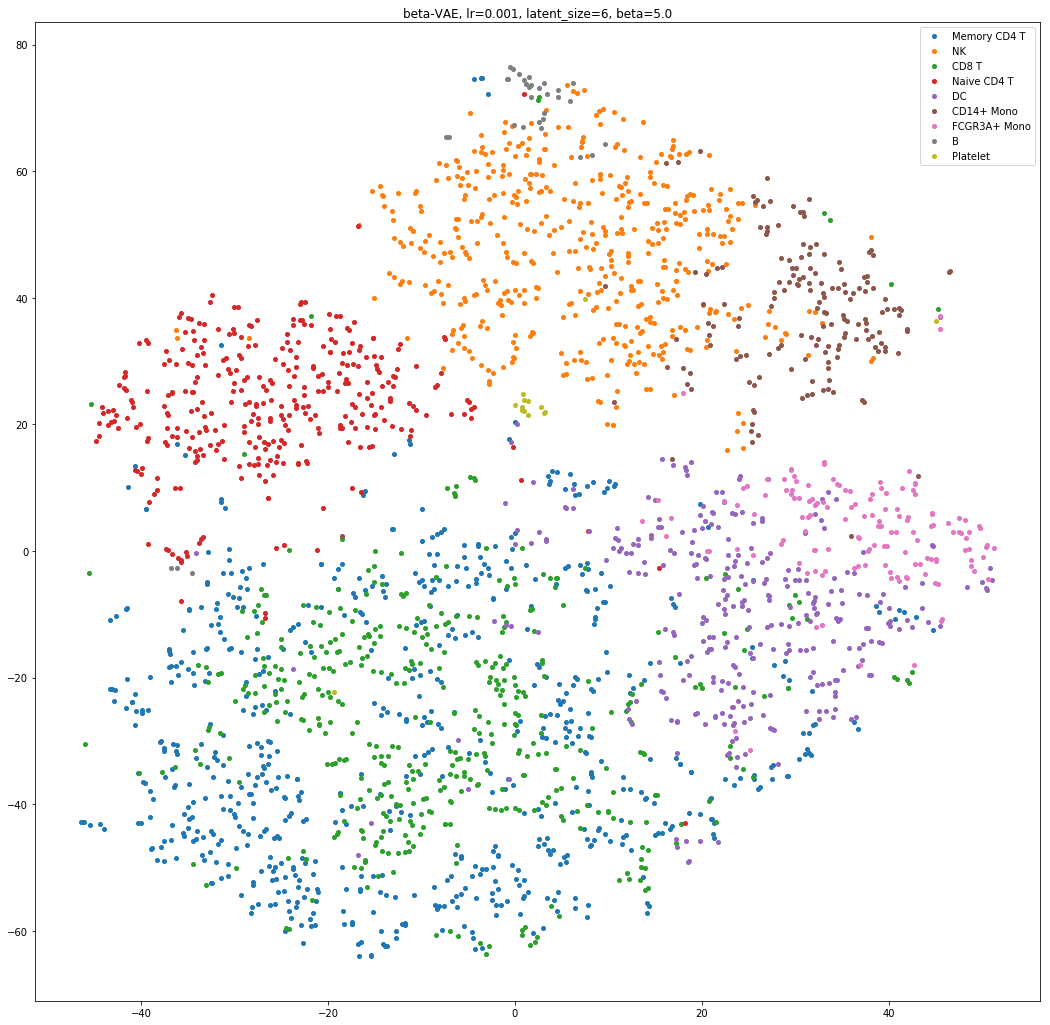

In [9]:
codes, labels = [], []

for i in range(len(train_loader.dataset)):
    mu, log_var = betaVae1.encode(train_loader.dataset.x_data[i].float())
    sample = betaVae1.reparameterize(mu, log_var)
    label = train_loader.dataset.y_data[i]
    labels.append(label.data.numpy())
    codes.append(sample.data.numpy())

    
codes = np.vstack(codes)
print("Model training time:", datetime.timedelta(seconds=round(t1-t0,0)))
plot_tsne(codes, labels, title='beta-VAE, lr=0.001, latent_size=6, beta=2.0')

## $\beta$-VSC

In [4]:
betaVSC = betaVSC(latent_size=6)
betaVSC.to(device)
optimizer = torch.optim.Adam(betaVSC.parameters(), lr=0.001)

In [5]:
t0=time.time()
train_VSC(beta=2.0, VSC=betaVSC, train_loader=train_loader, device=device, optimizer=optimizer)
t1=time.time()

loss:  982386.625 epoch:  0
loss:  550132.875 epoch:  1
loss:  486565.9375 epoch:  2
loss:  479563.3125 epoch:  3
loss:  472329.25 epoch:  4
loss:  472425.6875 epoch:  5
loss:  467311.375 epoch:  6
loss:  474058.125 epoch:  7
loss:  456224.0 epoch:  8
loss:  446828.5 epoch:  9
loss:  450656.75 epoch:  10
loss:  442101.75 epoch:  11
loss:  448983.28125 epoch:  12
loss:  449447.84375 epoch:  13
loss:  449314.40625 epoch:  14
loss:  447346.96875 epoch:  15
loss:  436482.40625 epoch:  16
loss:  442950.21875 epoch:  17
loss:  434290.0625 epoch:  18
loss:  437773.71875 epoch:  19
loss:  433531.34375 epoch:  20
loss:  430604.875 epoch:  21
loss:  435295.96875 epoch:  22
loss:  434637.1875 epoch:  23
loss:  424680.75 epoch:  24
loss:  435191.625 epoch:  25
loss:  427231.9375 epoch:  26
loss:  435335.96875 epoch:  27
loss:  427400.03125 epoch:  28
loss:  430323.25 epoch:  29
loss:  432843.78125 epoch:  30
loss:  432229.03125 epoch:  31
loss:  428907.125 epoch:  32
loss:  426725.15625 epoch:  33

Model training time: 0:20:31
plotting latent space with tsne ... 


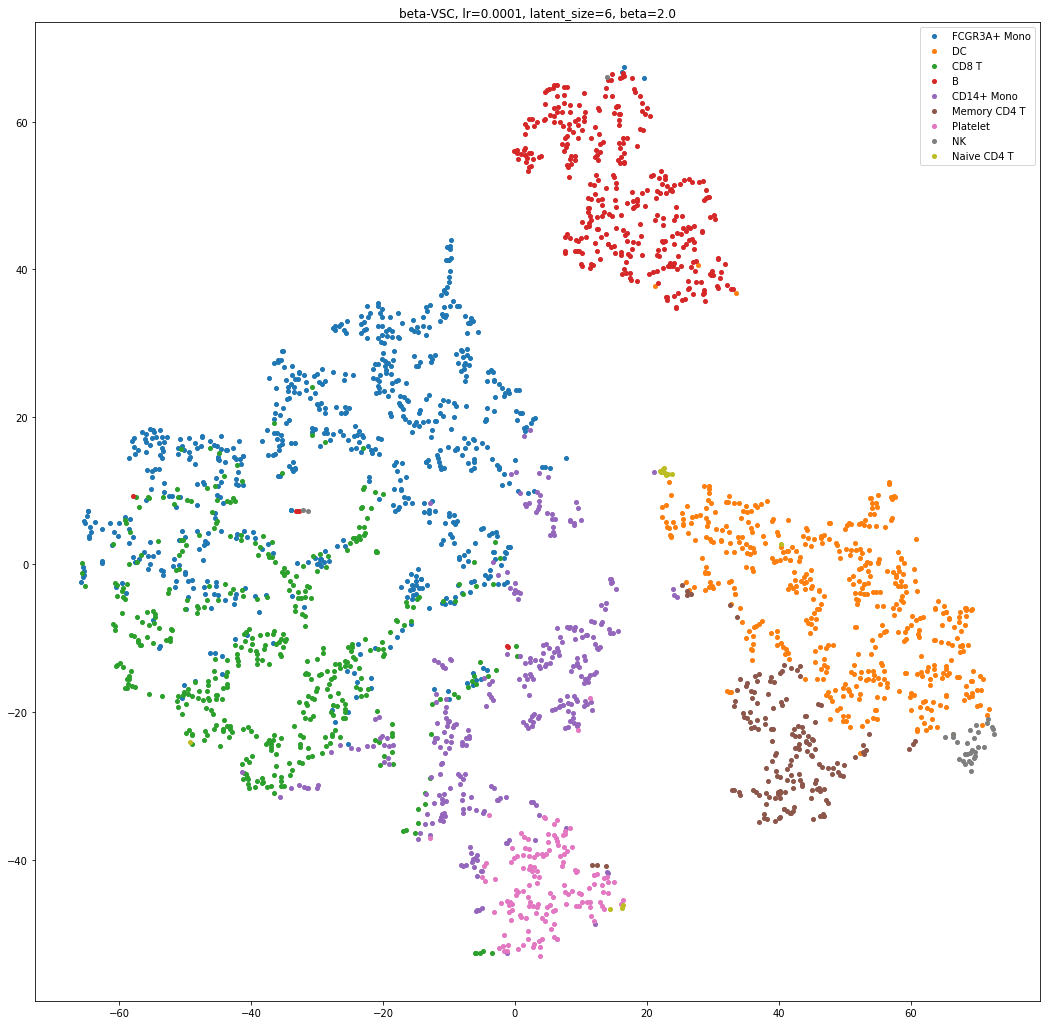

In [6]:
# TSNE-PLOT THE LATENT DIMENSION 
codes, labels = [], []

for i in range(len(train_loader.dataset)):
    mu, log_var, log_spike = betaVSC.encode(train_loader.dataset.x_data[i].float())
    sample = betaVSC.reparameterize(mu, log_var, log_spike)
    label = train_loader.dataset.y_data[i]
    labels.append(label.data.numpy())
    codes.append(mu.data.numpy())


print("Model training time:", datetime.timedelta(seconds=round(t1-t0,0)))
plot_tsne(codes, labels, title='beta-VSC, lr=0.001, latent_size=6, beta=2.0')